The cantons of Switzerland are aguably more independent from eachother than the Bundesländer of Germany or the States in the USA. One steriotype, is that people make more money in the German speaking cantons, and we show that this is untrue in the following graphics. Instead, it appears that people simply make the most money in Swiss cities rather than the countryside.

First we look at a graph depicting the location of the cantons. The data used for this graph was found using the google maps API$^{1}$ and more of my code for retrieval can be found within the github directory.

The second interactive graph helps us compare the GDP of the cantons over the past few years. The language information was taken from Wikipedia$^{2}$, and the GDP per Capita and number of residents per canton were taken from the Federal Statistics Office$^{3}$. Note that the Basel-Stadt canton has a much greater GDP per capita than Zürich. We also notice that many German speaking cantons have little GDP per capita and the average within the German speaking cantons is similar to Ticino. By clicking on any of the predominately rural or urban cantons in the bar graph, we see large diparities in the GDP compared to any language based average.

$^{1}$ https://cloud.google.com/maps-platform/

$^{2}$ https://en.wikipedia.org/wiki/Cantons_of_Switzerland

$^{3}$ https://www.bfs.admin.ch/bfs/en/home/statistics/national-economy/national-accounts/gross-domestic-product-canton.html

<IPython.core.display.Javascript object>


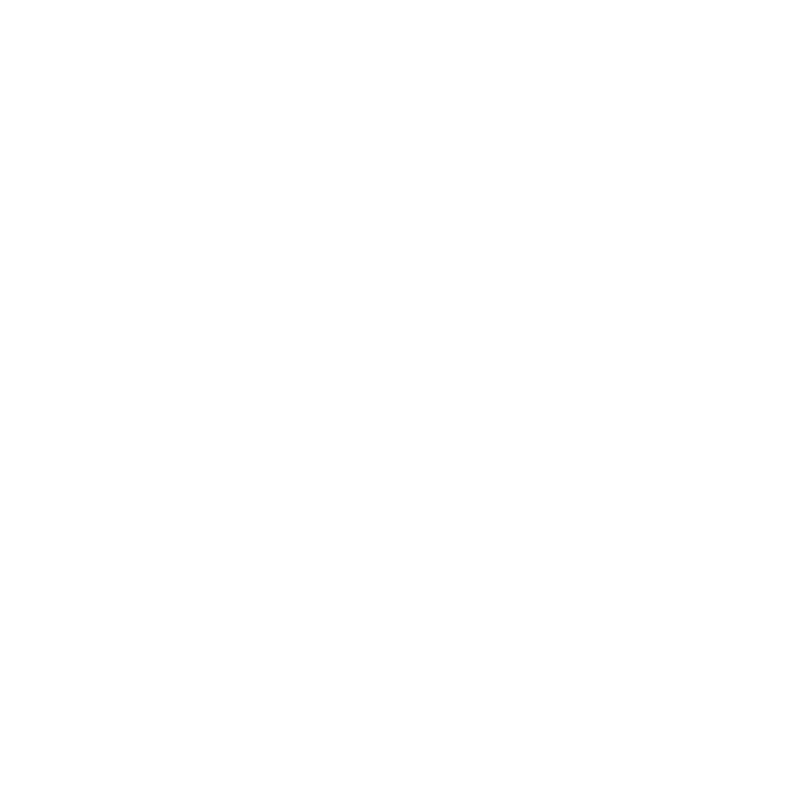

In [4]:
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def plot_cantons():
    locations = pd.read_csv('longitudelatitude.csv', index_col=0)
    long = locations['Longitude'].iloc[:-1].values
    lat = locations['Latitude'].iloc[:-1].values
   
    plt.figure(figsize=(8,8))
    plt.scatter(long, lat, c='r', alpha=0.7, s=200)
    return mplleaflet.display()

plot_cantons()

In [5]:
import numpy as np
import pandas as pd

# Clean and setup the language data
def getData():
    df = pd.read_csv('languages.csv')
    df = df[['Code', 'Canton of','Official languages']]
    df =df.set_index('Canton of')

    for language in ['German', 'French', 'Italian', 'Romansh']:
        df[language]=[language in df['Official languages'].loc[canton] for canton in df.index]
        df.loc['Switzerland',(language)]=False

    # Clean and setup the population data
    pop = pd.read_csv('population.csv')
    db = pd.DataFrame(index = pop['code'].unique())

    for year in range(2010,2017):
        mask = (pop['type']=='Permanent resident population') & (pop['year']==year)
        string = str(year)+ 'p'
        db.loc[:,string] = pop['population'].loc[mask].values

        mask = (pop['type']=='Non permanent resident population') & (pop['year']==year)
        string = str(year)+ 'n'
        db.loc[:,string] = pop['population'].loc[mask].values
   
        db[str(year)+'t']=db[str(year)+'p']+db[str(year)+'n']
    # Open the gdp data
    gdp = pd.read_csv('gdp.csv')
    gdp = gdp.rename(index=str, columns={"2015p": "2015"})

    for year in [str(num) for num in range(2008, 2016)]:
        gdp[year] = gdp[year].str.strip()
        gdp[year] = gdp[year].str.replace(',', '')
        gdp[year] = pd.to_numeric(gdp[year])

    gdp.index = gdp['Canton']

    # Open the longitude and latitude values
    locations = pd.read_csv('longitudelatitude.csv', index_col=0)

    # Join the data sets appropriately
    dk = pd.concat([df, gdp], axis=1, join='inner')
    dk = dk.set_index('Code')

    dk = pd.concat([dk, db], axis=1, join='inner')
    dk = pd.concat([dk, locations], axis=1, join='inner')

    #Change the gdp values to gdp per person
    for year in range(2010,2016):
   
        dk[str(year)]= dk.apply(lambda row: (1000000)*row[str(year)]/row[str(year)+'t'], axis=1)

    dk = dk.drop(['Official languages', '2008', '2009', '2016p', '2016n', '2016t'], axis=1)
    return dk
def plotLine(dk):
    years = [str(year) for year in range(2010, 2016)]
    # The following code is verbose, but very readable.
    german = dk.groupby( ['German'] )[years].mean().loc[True].values
    french = dk.groupby( ['French'] )[years].mean().loc[True].values
    italian = dk.groupby( ['Italian'] )[years].mean().loc[True].values
    romansh = dk.groupby( ['Romansh'] )[years].mean().loc[True].values

    plt.plot(np.arange(6), german, '--', color='red', label='German Speaking Cantons')
    plt.plot(np.arange(6), french, '--', color='blue', label='French Speaking Cantons')
    plt.plot(np.arange(6), italian, '--', color='green', label='Italian Speaking Cantons')
    plt.plot(np.arange(6), romansh, '--', color='yellow', label='Romansh Speaking Cantons')
    plt.plot(np.arange(6), dk[years].loc['CH'].values, '--', color='black', label='All of Switzerland')
    plt.xticks(np.arange(len(years)), years)

def getColor(row):
    if row['Romansh']:
        return 'yellow'
    elif row['Italian']:
        return 'green'
    elif row['French']:
        return 'blue'
    elif row['German']:
        return 'red'
    else:
        return 'black'

def onclick(event):
    years = [str(year) for year in range(2010, 2016)]
    plt.subplot(2, 1, 2)

    bars = get_bars(dk)
    cantonInterest = bars.index[round(float(event.xdata))]
    plotBar(dk)
    
    plt.subplot(2, 2, 1)
    plt.plot(np.arange(6), dk[years].loc[cantonInterest].values, '-o', color='tan',
             label='Canton of '+dk['Canton'].loc[cantonInterest])
    plt.gca().set_title('Canton {} chosen'.format(cantonInterest))
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


def get_bars(dk):
    years = [str(year) for year in range(2010, 2016)]
    bars = dk[years].apply(lambda row: np.mean(row[years]), axis=1)
    bars.sort_values(inplace=True, ascending=False)
    return bars
    
def plotBar(dk):#, cantonIndex):
    bars = get_bars(dk)
    #color = [(1,0,0) for canton in bars]
    colors = dk[['German', 'French', 'Italian', 'Romansh']].apply(lambda row: getColor(row), axis=1)
    colors = colors.reindex(bars.index)
    #color[cantonIndex]=(0,0,1)
    plt.bar(np.arange(len(dk)), bars.values, width = .5, edgecolor = 'black', color=colors)
    plt.xticks(np.arange(len(bars)), bars.index)
    plt.yticks([0, 50000, 100000, 150000])
    a = plt.gca().xaxis

# rotate the tick labels for the x axis
    for item in a.get_ticklabels():
        item.set_rotation(315)
# adjust the subplot so the text doesn't run off the image
    plt.subplots_adjust(bottom=0.25)

<IPython.core.display.Javascript object>


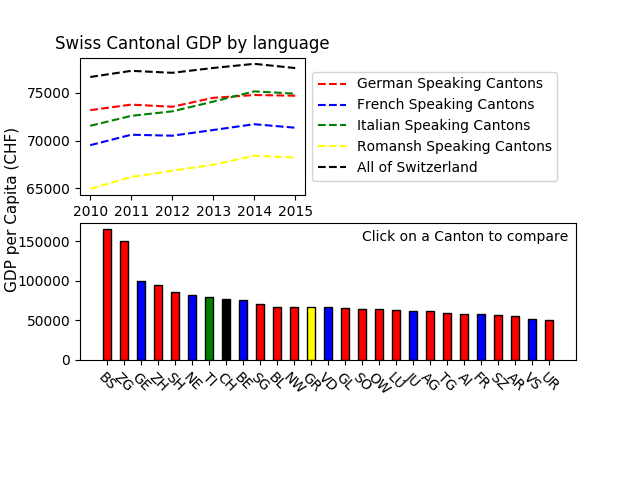

In [6]:
import matplotlib
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dk = getData()
# Plot the line Graph
plt.figure()

ax = plt.gca()

figsize=(10,10)
plt.subplot(2, 1, 2)
plt.text(-6, 280000,'GDP per Capita (CHF)', size=11, rotation=90)
plt.text(15, 150000,'Click on a Canton to compare', size=10, rotation=0)
plotBar(dk)
# tell mpl_connect we want to pass a 'button_press_event' into onclick when the event is detected
plt.gcf().canvas.mpl_connect('button_press_event', onclick)

plt.subplot(2, 2, 1)
plotLine(dk)
plt.title('Swiss Cantonal GDP by language')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()